<img src="https://avatars.githubusercontent.com/u/63704085?s=400&u=5dc6c45b7d457ce6f303fbc612091cb2c133482f&v=4" alt="sar2cube logo" style="float: top; max-width: 200px" />

## Use Case 3: Forest Change Detection

In [10]:
# Import necessary libraries
# System
import os
import sys
from time import time
from datetime import datetime
# Math
import math
import numpy as np
from scipy.optimize import curve_fit
# Geography
from osgeo import gdal, osr
from pyproj import Proj, transform, Transformer, CRS
import rasterio
# Datacubes and databases
import datacube
import xarray as xr
import rioxarray
import pandas as pd
# Parallel Computing
import dask
from dask.distributed import Client
from dask import delayed, compute
# Graphic
from matplotlib import pyplot as plt

from eo_utils import *
from sar2cube_utils import *

#from datacube.drivers.netcdf import write_dataset_to_netcdf

### Attach to the Dask Cluster

In [ ]:
client = Client('tcp://10.8.244.123:8786')
dask.config.set(**{'array.slicing.split_large_chunks': False})
client

## L0 Datacube loading

In [ ]:
dc = datacube.Datacube(config = '/home/mclaus@eurac.edu/.datacube.conf')
sent1 = dc.load(product = 'SAR2Cube_L0_117_ASC_ST_2016_2020', time=["2016-01-01","2020-12-31"], dask_chunks={'time':1,'x':2000,'y':2000})
sent1

## Spatial Slicing for forest area
The bright rectangle represents the area of interest we will analyze during this use case.
<img src="./auxdata/UC3/sar2cube_change_area.jpg" style="float: bottom; max-width: 720px" />

In [ ]:
start = time()
vaia_bbox = [11.399087905883789,46.32962443657124,11.435308456420898,46.351193305097866]
bbox_mask = np.bitwise_and(np.bitwise_and(sent1.grid_lon[0]>vaia_bbox[0],sent1.grid_lon[0]<vaia_bbox[2]),np.bitwise_and(sent1.grid_lat[0]>vaia_bbox[1],sent1.grid_lat[0]<vaia_bbox[3]))
sent1_subset = sent1.where(bbox_mask,drop=True)
print('Elapsed time: ', time()-start)
sent1_subset

## Amplitude and Multilook

In [ ]:
VV_amp_ML = ((sent1_subset.i_VV**2 + sent1_subset.q_VV**2)**0.5).coarsen(y=4,boundary='trim').mean().coarsen(x=19,boundary='trim').mean()
VH_amp_ML = ((sent1_subset.i_VH**2 + sent1_subset.q_VH**2)**0.5).coarsen(y=4,boundary='trim').mean().coarsen(x=19,boundary='trim').mean()

In [ ]:
sent1_subset = sent1_subset.drop('i_VH')
sent1_subset = sent1_subset.drop('i_VV')
sent1_subset = sent1_subset.drop('q_VH')
sent1_subset = sent1_subset.drop('q_VV')
sent1_ML = sent1_subset.coarsen(y=4,boundary='trim').mean().coarsen(x=19,boundary='trim').mean()

In [ ]:
sent1_ML['VV'] = VV_amp_ML
sent1_ML['VH'] = VH_amp_ML

In [ ]:
sent1_ML.time.attrs.pop('units', None)
sent1_ML.to_netcdf('/mnt/large_drive/work_spaces/mclaus/S1_forest/sent1_ML.nc')

In [ ]:
sent1_ML = xr.open_dataset('/mnt/large_drive/work_spaces/mclaus/S1_forest/sent1_ML.nc')
sent1_ML.VH[:,20,20].plot()

## Speckle Filtering

In [ ]:
def lee_enhanced(data,winsize=3):
    K_DEFAULT = 1.0
    CU_DEFAULT = 0.523
    CMAX_DEFAULT = 1.73
    tmp_data = np.zeros_like(data)    
    rows = data.shape[0]
    cols = data.shape[1]
    border = winsize//2
    Cu = CU_DEFAULT
    Cmax = CMAX_DEFAULT
    for i in range(border,rows-border):
        for j in range(border,cols-border):
            S = data[i-border:i+border+1,j-border:j+border+1].std()
            Im = data[i-border:i+border+1,j-border:j+border+1].mean()
            Ic = data[i,j]
            Ci = S / Im            
            if Ci<=Cu:
                tmp_data[i,j] = Im
            elif Cu < Ci < Cmax:
                W = np.exp(-K_DEFAULT*(Ci - Cu)/(Cmax - Ci))
                tmp_data[i,j] = Im * W + Ic * (1-W)
            else:
                tmp_data[i,j] = Ic            
    return tmp_data

In [ ]:
# Apply speckle filter (lee enhanced)
sent1_filtered_VV = xr.apply_ufunc(lee_enhanced,sent1_ML.VV,
                       vectorize=True,
                       input_core_dims=[['y','x']],# reduce along 'x'
                       output_core_dims=[['y','x']],
                       dask="parallelized",
                       output_dtypes=[float],
                       dask_gufunc_kwargs={'allow_rechunk':True}
                        )

sent1_filtered_VH = xr.apply_ufunc(lee_enhanced,sent1_ML.VH,
                       vectorize=True,
                       input_core_dims=[['y','x']],# reduce along 'x'
                       output_core_dims=[['y','x']],
                       dask="parallelized",
                       output_dtypes=[float],
                       dask_gufunc_kwargs={'allow_rechunk':True}
                        )

In [ ]:
sent1_ML['VV'] = sent1_filtered_VV
sent1_ML['VH'] = sent1_filtered_VH

In [ ]:
sent1_ML.to_netcdf('/mnt/large_drive/work_spaces/mclaus/S1_forest/sent1_ML_lee.nc')

In [ ]:
sent1_ML.VH[:,20,20].plot()
sent1_ML = xr.open_dataset('/mnt/large_drive/work_spaces/mclaus/S1_forest/sent1_ML_lee.nc')
sent1_ML.VH[:,20,20].plot()

## Geocoding

Define the output projection and resolution.

In [ ]:
spatialres = 20
output_crs = "epsg:32632"

Create a grid aligned with the Sentinel-2 one.

In [ ]:
x_regular, y_regular, grid_x_irregular, grid_y_irregular = create_S2grid(sent1_ML,output_crs,spatialres)
grid_x_regular, grid_y_regular = np.meshgrid(x_regular,y_regular)
grid_x_regular

## Geocoded time-series

In [ ]:
# Compute the transformation only once
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator

geocoded_cube = xr.Dataset(
    {
        "VV": (["time","y", "x"], np.zeros((len(sent1_ML.time),len(y_regular),len(x_regular)))),
        "VH": (["time","y", "x"], np.zeros((len(sent1_ML.time),len(y_regular),len(x_regular))))
    }, 
    coords={
        "time": (["time"],sent1_ML.time.values),
        "y": (["y"],y_regular),
        "x": (["x"],x_regular)
    },
)

grid_irregular_flat = np.asarray([grid_x_irregular.flatten(), grid_y_irregular.flatten()]).T
grid_regular_flat = np.asarray([grid_x_regular.flatten(), grid_y_regular.flatten()]).T
shape = grid_x_regular.shape

In [ ]:
%time delaunay_obj = Delaunay(np.asarray([grid_x_irregular.flatten(), grid_y_irregular.flatten()]).T)  # Compute the triangulation

In [ ]:
def geocode(delaunay,datacube,grid_reg_flat,shape):
    interpolator  = LinearNDInterpolator(delaunay,datacube)
    geocoded_data = interpolator(grid_reg_flat)
    geocoded_data = geocoded_data.reshape(shape)
    return geocoded_data

In [ ]:
%%time
for i in range(len(sent1_ML.time)):
    geocoded_cube['VV'][i] = delayed(geocode)(delaunay_obj, sent1_ML.VV[i].values.flatten(),grid_regular_flat,grid_x_regular.shape).compute()
    geocoded_cube['VH'][i] = delayed(geocode)(delaunay_obj, sent1_ML.VH[i].values.flatten(),grid_regular_flat,grid_x_regular.shape).compute()

In [ ]:
# geocoded_cube.to_netcdf('sar2cube_vaia_timeseries.nc')

In [11]:
geocoded_cube = xr.open_dataset('/mnt/large_drive/work_spaces/mclaus/S1_forest/sar2cube_vaia_timeseries.nc').fillna(0)
geocoded_cube

<xarray.Dataset>
Dimensions:  (time: 181, x: 144, y: 124)
Coordinates:
  * time     (time) datetime64[ns] 2016-09-08T23:59:59 ... 2020-01-27T23:59:59
  * y        (y) float64 5.133e+06 5.134e+06 5.134e+06 ... 5.136e+06 5.136e+06
  * x        (x) float64 6.846e+05 6.846e+05 6.846e+05 ... 6.874e+05 6.874e+05
Data variables:
    VV       (time, y, x) float64 48.21 33.06 17.91 2.757 ... 0.0 0.0 0.0 0.0
    VH       (time, y, x) float64 41.84 28.69 15.54 2.392 ... 0.0 0.0 0.0 0.0

In [12]:
sent1 = geocoded_cube

## Sample visualization of the geocoded data

In [13]:
center = [46.34, 11.41]
zoom = 15

eoMap = openeoMap(center,zoom)
addLayer2(eoMap,sent1.VV[0].assign_attrs(crs=32632),'VV ' + str(geocoded_cube.time[0].values),clip=[0,200])
addLayer2(eoMap,sent1.VH[0].assign_attrs(crs=32632),'VH ' + str(geocoded_cube.time[0].values),clip=[0,200])
eoMap.map

Map(center=[46.34, 11.41], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

### Forest masking
We mask out forests using LISS Land Cover map from 2012

In [14]:
forest_mask = xr.open_rasterio('./auxdata/UC3/Liss_vaia_20m.tif')[0]
forest_mask = (forest_mask.where(forest_mask==315)/315).fillna(0)

In [15]:
sent1 = forest_mask * geocoded_cube

### Definition of seasonal periodic functions

In [16]:
def timeseries_function_season(x,a0,a1,a2):
    t=365.25
    return a0+(a1*np.cos(2*np.pi/t*x)+a2*np.sin(2*np.pi/t*x))
def fit_curve(x,y):
    index = np.nonzero(y) # We don't consider zero values (masked) for fitting.
    x = x[index]
    y = y[index]
    if len(y)<12:
        return np.array([0,0,0])
    popt, pcov = curve_fit(timeseries_function_season, x, y)
    return popt
def timeseries_function_season_2 (x,params):
    a0 = params[:,:,0]
    a1 = params[:,:,1]
    a2 = params[:,:,2]
    t=365.25
    return a0+(a1*np.cos(2*np.pi/t*x)+a2*np.sin(2*np.pi/t*x))

## Definition of training period
### We use the first 2 years of data, from September 2016 up to September 2018

In [17]:
dates = sent1.time.values
sDates = [ ((x - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')) for x in dates]
julian_dates = [ int((sDates[i]-sDates[0])/60/60/24) for i in range(len(sDates)) ] # Conversion to Julian day
julian_dates = np.asarray(julian_dates)
sent1['time'] = julian_dates
sent1_train = sent1.loc[dict(time=slice(0,730))] ## Use the first 2 years

We compute the seasonal function fit parameters over the Intensity time-series for both polarizations.

In [18]:
popts3d_VV = xr.apply_ufunc(fit_curve,sent1_train.time,sent1_train.VV,
                       vectorize=True,
                       input_core_dims=[['time'],['time']],# reduce along 'x'
                       output_core_dims=[['params']],
                       dask="parallelized",
                       output_dtypes=[float],
                       dask_gufunc_kwargs={'allow_rechunk':True,'output_sizes':{'params':3}}
                        )
popts3d_VH = xr.apply_ufunc(fit_curve,sent1_train.time,sent1_train.VH,
                       vectorize=True,
                       input_core_dims=[['time'],['time']],# reduce along 'x'
                       output_core_dims=[['params']],
                       dask="parallelized",
                       output_dtypes=[float],
                       dask_gufunc_kwargs={'allow_rechunk':True,'output_sizes':{'params':3}}
                        )

In [19]:
predicted_VV = timeseries_function_season_2(sent1.time,popts3d_VV)
predicted_VH = timeseries_function_season_2(sent1.time,popts3d_VH)

In [20]:
sent1_predicted = sent1.copy(deep=True)
sent1_predicted['VV'] = predicted_VV.T
sent1_predicted['VH'] = predicted_VH.T

In [21]:
sent1_predicted.to_netcdf('/mnt/large_drive/work_spaces/mclaus/S1_forest/sar2cube_timeseries_predicted.nc')

In [22]:
center = [46.34, 11.41]
zoom = 15

eoMap = openeoMap(center,zoom)
addLayer2(eoMap,geocoded_cube.VV[0].assign_attrs(crs=32632),'VV ' + str(geocoded_cube.time[0].values),clip=[0,200])
addLayer2(eoMap,geocoded_cube.VH[0].assign_attrs(crs=32632),'VH ' + str(geocoded_cube.time[0].values),clip=[0,200])
eoMap.map

Map(center=[46.34, 11.41], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [ ]:
print("Selected point coordinates in WGS84: ",eoMap.point_coords)
transformer = Transformer.from_crs("epsg:4326", "epsg:32632")
x,y = transformer.transform(eoMap.point_coords[1],eoMap.point_coords[0])
print("Selected point coordinates in UTM32: ",[x,y])

In [ ]:
px_timeseries = sent1.loc[dict(x=find_nearest(sent1.x.values,x),y=find_nearest(sent1.y.values,y))]
params_VH_sel = np.expand_dims(popts3d_VH.loc[dict(x=find_nearest(sent1.x.values,x),y=find_nearest(sent1.y.values,y))],axis=(0,1))
params_VV_sel = np.expand_dims(popts3d_VV.loc[dict(x=find_nearest(sent1.x.values,x),y=find_nearest(sent1.y.values,y))],axis=(0,1))

Area affected by Vaia storm

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
vh_line, = ax1.plot(dates,px_timeseries.VH)
vh_line.set_label('VH INT values')
vh_pred, = ax1.plot(dates, timeseries_function_season_2(julian_dates, params_VH_sel)[0], 'r-')
vh_pred.set_label('VH seasonal trend')
ax1.set_title('Geocoded VH Intensity')
ax1.legend()
vv_line, = ax2.plot(dates,px_timeseries.VV)
vv_line.set_label('VV INT values')
vv_pred, = ax2.plot(dates, timeseries_function_season_2(julian_dates, params_VV_sel)[0], 'r-')
vv_pred.set_label('VV seasonal trend')
ax2.set_title('Geocoded VV Intensity')
ax2.legend()
ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)

In [ ]:
x_ml, y_ml = find_closest_2d(sent1_ML,eoMap.point_coords)
subset = sent1_ML.loc[dict(x=x_ml,y=y_ml)]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
vh_line, = ax1.plot(dates,subset.VH[:,0,0])
vh_line.set_label('VH INT values')
ax1.set_title('SAR VH Intensity')
ax1.legend()
vv_line, = ax2.plot(dates,subset.VV[:,0,0])
vv_line.set_label('VV INT values')
ax2.set_title('SAR VV Intensity')
ax2.legend()
ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)

Area not affected by the storm

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
vh_line, = ax1.plot(dates,px_timeseries.VH)
vh_line.set_label('VH INT values')
vh_pred, = ax1.plot(dates, timeseries_function_season_2(julian_dates, params_VH_sel)[0], 'r-')
vh_pred.set_label('VH seasonal trend')
ax1.set_title('VH Intensity full time-series')
ax1.legend()
vv_line, = ax2.plot(dates,px_timeseries.VV)
vv_line.set_label('VV INT values')
vv_pred, = ax2.plot(dates, timeseries_function_season_2(julian_dates, params_VV_sel)[0], 'r-')
vv_pred.set_label('VV seasonal trend')
ax2.set_title('VV Intensity full time-series')
ax2.legend()
ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)

## Change alarms computation

We compute the difference between the predicted and real data

In [23]:
sent1_train_predicted = sent1_predicted.loc[dict(time=slice(0,730))] ## Use the first 2 years

In [24]:
sent1_diff_train = (sent1_train_predicted - sent1_train)
sent1_diff_train = sent1_diff_train.to_array()

In [25]:
sent1_diff_tot = sent1_predicted - sent1
sent1_diff_tot = sent1_diff_tot.to_array()

With the difference between real and predicted values, we compute the RMSE for every pixel in training set and the STD along time.

In [26]:
var_numb = len(sent1_diff_train.variable)
rmse_train = xr.ufuncs.sqrt((sent1_diff_train**2).sum('variable')/var_numb)
rmse_train_std  = rmse_train.std('time')

We do the same for the full time-series, which includes the test set.

In [27]:
rmse_tot = xr.ufuncs.sqrt((sent1_diff_tot**2).sum('variable')/var_numb)

We count as an alarm if the values of 5 subsequent acquisition have a RMSE > 3*sigma

In [28]:
alarms = rmse_tot > 3*rmse_train_std ## Use the first 2 years
alarms_filt = alarms.rolling(time=5, center=False).mean().fillna(0)

In [29]:
center = [46.34, 11.41]
zoom = 15

eoMap3 = openeoMap(center,zoom)
addLayer2(eoMap3,geocoded_cube.VV[0].assign_attrs(crs=32632),'VV ' + str(geocoded_cube.time[0].values),clip=[0,200])
addLayer2(eoMap3,geocoded_cube.VH[0].assign_attrs(crs=32632),'VH ' + str(geocoded_cube.time[0].values),clip=[0,200])
eoMap3.map

Map(center=[46.34, 11.41], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [34]:
print("Selected point coordinates in WGS84: ",eoMap3.point_coords)
transformer = Transformer.from_crs("epsg:4326", "epsg:32632")
x,y = transformer.transform(eoMap3.point_coords[1],eoMap3.point_coords[0])
print("Selected point coordinates in UTM32: ",[x,y])

Selected point coordinates in WGS84:  [11.417288, 46.342141]
Selected point coordinates in UTM32:  [686016.6520249762, 5134902.580728898]


In [35]:
px_timeseries = sent1.loc[dict(x=find_nearest(sent1.x.values,x),y=find_nearest(sent1.y.values,y))]
params_VH_sel = np.expand_dims(popts3d_VH.loc[dict(x=find_nearest(sent1.x.values,x),y=find_nearest(sent1.y.values,y))],axis=(0,1))
params_VV_sel = np.expand_dims(popts3d_VV.loc[dict(x=find_nearest(sent1.x.values,x),y=find_nearest(sent1.y.values,y))],axis=(0,1))
alarm_series = alarms_filt.loc[dict(x=find_nearest(sent1.x.values,x),y=find_nearest(sent1.y.values,y))]

In [36]:
alarm_index = np.argmax(alarm_series.values>=0.8)
if alarm_index!=0:
    print("Change detected at date:",str(dates[alarm_index])[:10])
else:
    print("No change detected!")

Change detected at date: 2019-07-25


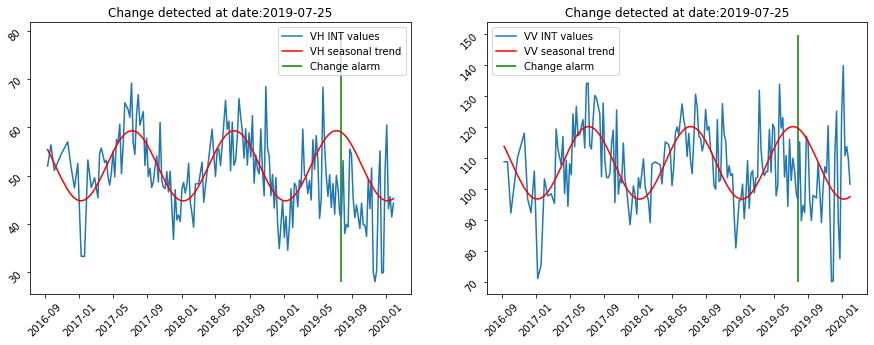

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
vh_line, = ax1.plot(dates,px_timeseries.VH)
vh_line.set_label('VH INT values')
vh_pred, = ax1.plot(dates, timeseries_function_season_2(julian_dates, params_VH_sel)[0], 'r-')
vh_pred.set_label('VH seasonal trend')
ax1.vlines(x = dates[alarm_index], ymin = px_timeseries.VH.min().values, ymax = px_timeseries.VH.max().values + 10, 
           colors = 'green', 
           label = 'Change alarm')
ax1.set_title("Change detected at date:"+str(dates[alarm_index])[:10])
ax1.legend()
ax1.tick_params(labelrotation=45)
vv_line, = ax2.plot(dates,px_timeseries.VV)
vv_line.set_label('VV INT values')
vv_pred, = ax2.plot(dates, timeseries_function_season_2(julian_dates, params_VV_sel)[0], 'r-')
vv_pred.set_label('VV seasonal trend')
ax2.set_title('VV Intensity full time-series')
ax2.vlines(x = dates[alarm_index], ymin = px_timeseries.VV.min().values, ymax = px_timeseries.VV.max().values + 10, 
           colors = 'green', 
           label = 'Change alarm')
ax2.set_title("Change detected at date:"+str(dates[alarm_index])[:10])
ax2.legend()
ax2.tick_params(labelrotation=45)

In [ ]:
addLayer2(eoMap3,alarms_filt[alarm_index].T.assign_attrs(crs=32632),"Alarms on "+str(dates[alarm_index])[:10],clip=[0.5,1])